# 1 задание: умножение
Как требовалось, рассмотрим 3 подхода к реализации умножения в питоне: обычное (руками), через опции jit (использование скомпилированных команд) и через dot в библиотеке numpy.

Для измерения эффективности того или иного способа будем замерять время выполнения умножений квадратных матриц.

In [1840]:
import numpy as np
from numba import njit
import time
import psutil
import os
import pandas as pd
import matplotlib.pyplot as plt
import math

def get_cpu_time(): # Функция для получения времени использования CPU текущим процессом
    process = psutil.Process(os.getpid()) # Получаем информацию о процессе
    return process.cpu_times().user + process.cpu_times().system # Возвращаем сумму пользовательского и системного времени CPU

Функции умножения матриц

In [1841]:
def manual_matrix_multiply(A, B):
    n = A.shape[0]
    C = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            for k in range(n):
                C[i, j] += A[i, k] * B[k, j]

    return C

@njit
def numba_matrix_multiply(A, B, C, n):

    for i in range(n):
        for j in range(n):
            for k in range(n):
                C[i, j] += A[i, k] * B[k, j]

    return C

def numpy_dot_multiply(A, B):
    return np.dot(A, B)

Также рассмотрим умножение на С++

- Обычное умножение
```
for (int i = 0; i < N; ++i) {
	for (int j = 0; j < N; ++j) {
		for (int k = 0; k < N; ++k) {
			C[i * N + j] += A[i * N + k] * B[k * N + j];
		}
	}
}
```
- Продвинутое умножение
```
#pragma omp parallel for collapse(2)
for (int i = 0; i < N; i += blockSize) {
	for (int j = 0; j < N; j += blockSize) {
		for (int k = 0; k < N; k += blockSize) {
			for (int ii = 0; ii < blockSize; ++ii) {
				for (int jj = 0; jj < blockSize; jj += 4) {
					__m256d c = _mm256_load_pd(&C[(i + ii) * N + (j + jj)]);
					for (int kk = 0; kk < blockSize; kk += 4) {
						__m256d a = _mm256_load_pd(&A[(i + ii) * N + (k + kk)]);
						__m256d b = _mm256_load_pd(&B[(j + jj) * N + (k + kk)]);
						c = _mm256_add_pd(c, _mm256_mul_pd(a, b));
					}
					_mm256_store_pd(&C[(i + ii) * N + (j + jj)], c);
				}
			}
		}
	}
}
```
- Умножение Eigen
```
Eigen::MatrixXd C = A * B;
```

# Анализ производительности
### Умножение на Python
На основе этих функций были проведены замеры времени работы. Каждая функция умножения проверялась с увеличением сложности работы: начиная с малых матриц, затем увеличивая их размер. Всего было проведено 5 серий замеров.

Исходный код программы тестирования: **multiply.py**

Все полученные данные находятся в папке **data**:
- **manualy.txt** - обычное умножение на Python
- **jit.txt** - умножение с помощью jit
- **dot.txt** - умножение с помощью numpy.dot

Во всех файлах в каждой строчке записаны: **<размер матриц>,<время умножения>**

Загружаем эти данные и сразу приводим времена с одинаковым размером в рамках одной функции к одному среднему

In [1842]:
data = pd.read_csv('data/manualy.txt', header=None)
x_manualy_raw = np.array(data[0])
y_manualy_raw = np.array(data[1])

manualy = np.empty((0,3))

for i in range(len(x_manualy_raw)):
    if (x_manualy_raw[i] in manualy[:,0]):
        manualy[x_manualy_raw[i] // 8 - 1, 1] = manualy[x_manualy_raw[i] // 8 - 1, 1] + y_manualy_raw[i]
        manualy[x_manualy_raw[i] // 8 - 1, 2] = manualy[x_manualy_raw[i] // 8 - 1, 2] + 1
    else:
        manualy = np.vstack([manualy,np.array([[x_manualy_raw[i],y_manualy_raw[i],1]])])
        
manualy[:,1] = manualy[:,1] / manualy[:,2]

In [1843]:
data = pd.read_csv('data/jit.txt', header=None)
x_jit_raw = np.array(data[0])
y_jit_raw = np.array(data[1])

jit = np.empty((0,3))

for i in range(len(x_jit_raw)):
    if (x_jit_raw[i] in jit[:,0]):
        jit[x_jit_raw[i] // 32 - 1, 1] = jit[x_jit_raw[i] // 32 - 1, 1] + y_jit_raw[i]
        jit[x_jit_raw[i] // 32 - 1, 2] = jit[x_jit_raw[i] // 32 - 1, 2] + 1
    else:
        jit = np.vstack([jit,np.array([[x_jit_raw[i],y_jit_raw[i],1]])])
        
jit[:,1] = jit[:,1] / jit[:,2]

In [1844]:
data = pd.read_csv('data/dot.txt', header=None)
x_dot_raw = np.array(data[0])
y_dot_raw = np.array(data[1])

dot = np.empty((0,3))

for i in range(len(x_dot_raw)):
    if (x_dot_raw[i] in dot[:,0]):
        dot[x_dot_raw[i] // 64 - 1, 1] = dot[x_dot_raw[i] // 64 - 1, 1] + y_dot_raw[i]
        dot[x_dot_raw[i] // 64 - 1, 2] = dot[x_dot_raw[i] // 64 - 1, 2] + 1
    else:
        dot = np.vstack([dot,np.array([[x_dot_raw[i],y_dot_raw[i],1]])])
        
dot[:,1] = dot[:,1] / dot[:,2]

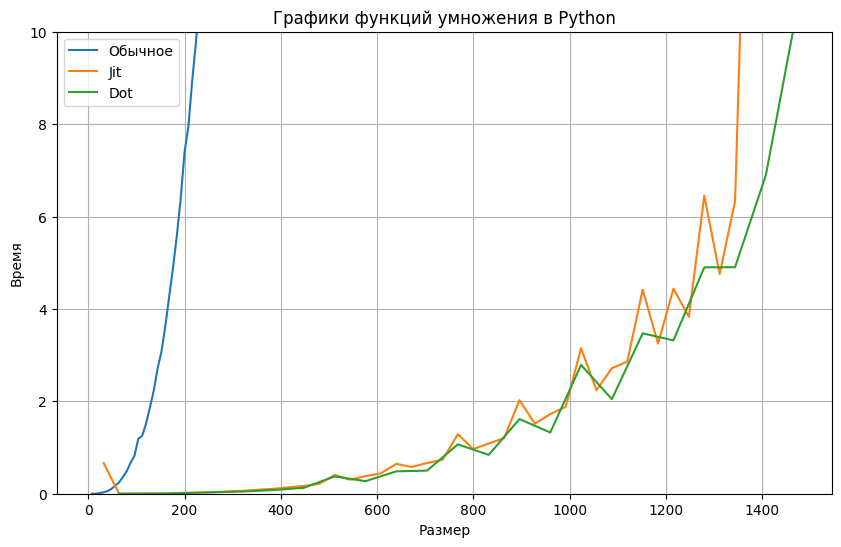

In [1845]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(manualy[:,0], manualy[:,1], label='Обычное')
plt.plot(jit[:,0], jit[:,1], label='Jit')
plt.plot(dot[:,0], dot[:,1], label='Dot')

plt.title('Графики функций умножения в Python')
plt.xlabel('Размер')
plt.ylabel('Время')
plt.ylim(0,10)

plt.legend()

plt.grid()
plt.show()

Как видно из графика выше, хуже всех оказывается обычное умножение руками - что достаточно очевидно, ведь Python язык интерпретируемый, и множество операций с памятью происходят с большой задержкой. Jit и dot намного лучше справляются с этим, как минимум потому, что в основе умножений в обоих случаях будет выступать низкоуровневый код (асемблер и С/С++), который требует предварительной компиляции (что и приводит к оптимизации). Уже такой код может быть даже легко предсказуем для аппаратуры для более эффективного размещения в кэше.

Необычным является и тот факт, что dot и jit не отличаются, что довольно необычно.

### Умножение на C++

Попробуем, помимо заявленных способов, использовать С++ и реализуем 3 способа умножения: обычный ручной, продвинутый ручной (распараллеливание, блочное умножение, SIMD инструкции) и библиотечное умножение Eigen (сторонняя библиотека).

Соответствующий код можно посмотреть в файле: **multiply.cpp**

Исходный код программы тестирования: **multiply.py**

Все полученные данные находятся в папке **data**:
- **simple_times.txt** - обычное умножение на c++
- **manual_times.txt** - продвинутое умножение на с++, включающая в себя такие методы как: блочное умножение, распараллеливание и использование векторых SIMD инструкций
- **eigen_times.txt** - умножение с помощью сторонней библиотеки Eigen

Во всех файлах в каждой строчке записаны: **<размер матриц>,<время умножения>**

Загружаем эти данные и сразу приводим времена с одинаковым размером в рамках одной функции к одному среднему

In [1846]:
data = pd.read_csv('data/eigen_times.txt', header=None)
x_eigen_raw = np.array(data[0])
y_eigen_raw = np.array(data[1])

eigen = np.empty((0,3))

for i in range(len(x_eigen_raw)):
    if (x_eigen_raw[i] in eigen[:,0]):
        eigen[x_eigen_raw[i] // 64 - 1, 1] = eigen[x_eigen_raw[i] // 64 - 1, 1] + y_eigen_raw[i]
        eigen[x_eigen_raw[i] // 64 - 1, 2] = eigen[x_eigen_raw[i] // 64 - 1, 2] + 1
    else:
        eigen = np.vstack([eigen,np.array([[x_eigen_raw[i],y_eigen_raw[i],1]])])
        
eigen[:,1] = eigen[:,1] / eigen[:,2]

In [1847]:
data = pd.read_csv('data/manual_times.txt', header=None)
x_pro_raw = np.array(data[0])
y_pro_raw = np.array(data[1])

pro = np.empty((0,3))

for i in range(len(x_pro_raw)):
    if (x_pro_raw[i] in pro[:,0]):
        pro[x_pro_raw[i] // 64 - 1, 1] = pro[x_pro_raw[i] // 64 - 1, 1] + y_pro_raw[i]
        pro[x_pro_raw[i] // 64 - 1, 2] = pro[x_pro_raw[i] // 64 - 1, 2] + 1
    else:
        pro = np.vstack([pro,np.array([[x_pro_raw[i],y_pro_raw[i],1]])])
        
pro[:,1] = pro[:,1] / pro[:,2]

In [1848]:
data = pd.read_csv('data/simple_times.txt', header=None)
x_simple_raw = np.array(data[0])
y_simple_raw = np.array(data[1])

simple = np.empty((0,3))

for i in range(len(x_simple_raw)):
    if (x_simple_raw[i] in simple[:,0]):
        simple[x_simple_raw[i] // 64 - 1, 1] = simple[x_simple_raw[i] // 64 - 1, 1] + y_simple_raw[i]
        simple[x_simple_raw[i] // 64 - 1, 2] = simple[x_simple_raw[i] // 64 - 1, 2] + 1
    else:
        simple = np.vstack([simple,np.array([[x_simple_raw[i],y_simple_raw[i],1]])])
        
simple[:,1] = simple[:,1] / simple[:,2]

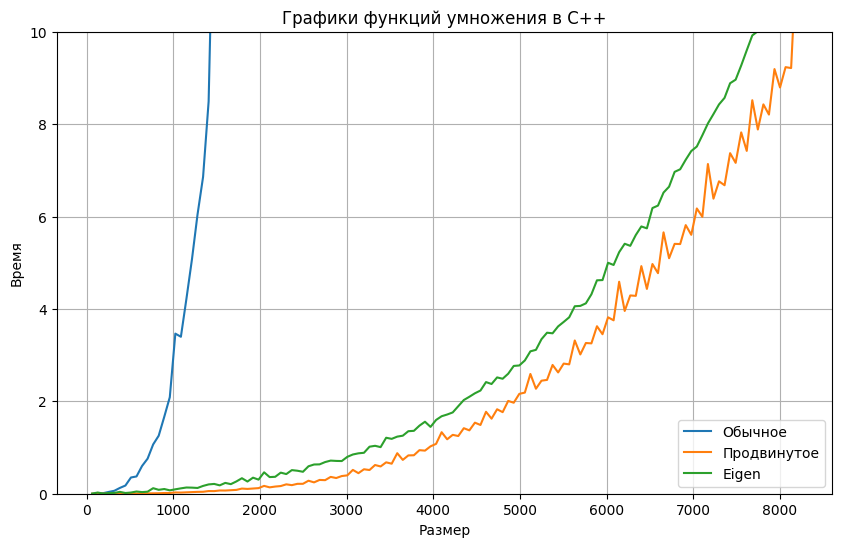

In [1849]:
plt.figure(figsize=(10, 6))

plt.plot(simple[:,0], simple[:,1], label='Обычное')
plt.plot(pro[:,0], pro[:,1], label='Продвинутое')
plt.plot(eigen[:,0], eigen[:,1], label='Eigen')
plt.title('Графики функций умножения в C++')
plt.xlabel('Размер')
plt.ylabel('Время')
plt.ylim(0,10)

plt.legend()

plt.grid()
plt.show()

Заметно сильное различие между обычным умножением и остальными способами. Продвинутое умножение и умножение с Eigen почти на порядок лучше обычного, к тому же, продвинутое немного лучше чем умножение Eigen.

### Общее сравнение

Интересно будет рассмотреть все методы умножения на одном графике

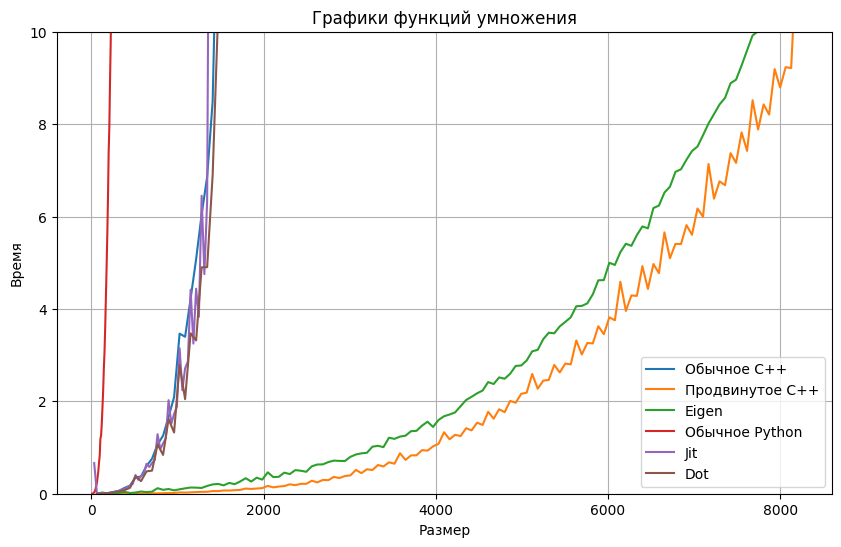

In [1850]:
plt.figure(figsize=(10, 6))

# Строим графики для каждого набора данных
plt.plot(simple[:,0], 	simple[:,1], 	label='Обычное С++')
plt.plot(pro[:,0], 		pro[:,1], 		label='Продвинутое C++')
plt.plot(eigen[:,0], 	eigen[:,1], 	label='Eigen')
plt.plot(manualy[:,0], 	manualy[:,1], 	label='Обычное Python')
plt.plot(jit[:,0], 		jit[:,1], 		label='Jit')
plt.plot(dot[:,0], 		dot[:,1], 		label='Dot')

# Добавляем заголовок и подписи осей
plt.title('Графики функций умножения')
plt.xlabel('Размер')
plt.ylabel('Время')
plt.ylim(0,10)

# Добавляем легенду
plt.legend()

# Отображаем график
plt.grid()
plt.show()


Изходя из этого графика, можно сделать следующие выводы:
1) Самыми лучшими способами умножения являются: продвинутое на с++ и Eigen
2) Самым худшим является обычное умножение в Python
3) Dot функция от numpy, использование Jit оптимизатора, обычное умножение на с++ - ничем между собой не отличаются.

Последний факт остаётся необъяснимым: ожидалось, что jit будет схож по результатам с обычным умножением на с++, так как при добавлении такого тега к функции, все её операции попытаются быть заменены на компилируемый код; также ожидалось, что numpy.dot будет лучше (хотя бы немного) чем первые два способа.

**В качестве способа умножения остановимся на numpy.dot из-за простоты и возможности реализовывать дальнейшую работу на Python** (хоть в с++ есть способы умножать матрицы эффективнее, реализация исходной задачи будет сильно обременена написанием кода)

Для дополнительной наглядности и оценки асимптотичности, построим график от всех сырых данных, но в логарифмическом масштабе.

C:\Users\fedor\AppData\Local\Temp\ipykernel_8292\3364797171.py:10: RuntimeWarning: divide by zero encountered in log
  y_dot_raw 		= np.log(y_dot_raw)
C:\Users\fedor\AppData\Local\Temp\ipykernel_8292\3364797171.py:12: RuntimeWarning: divide by zero encountered in log
  y_jit_raw 		= np.log(y_jit_raw)
C:\Users\fedor\AppData\Local\Temp\ipykernel_8292\3364797171.py:13: RuntimeWarning: divide by zero encountered in log
  y_manualy_raw 	= np.log(y_manualy_raw)


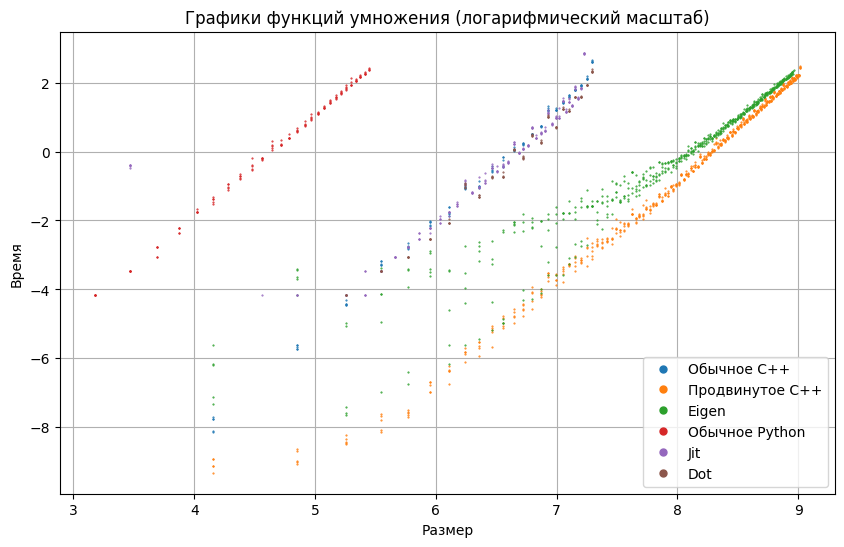

In [1851]:
plt.figure(figsize=(10, 6))

x_dot_raw 		= np.log(x_dot_raw)
x_eigen_raw 	= np.log(x_eigen_raw)
x_jit_raw 		= np.log(x_jit_raw)
x_manualy_raw 	= np.log(x_manualy_raw)
x_pro_raw 		= np.log(x_pro_raw)
x_simple_raw 	= np.log(x_simple_raw)

y_dot_raw 		= np.log(y_dot_raw)
y_eigen_raw 	= np.log(y_eigen_raw)
y_jit_raw 		= np.log(y_jit_raw)
y_manualy_raw 	= np.log(y_manualy_raw)
y_pro_raw 		= np.log(y_pro_raw)
y_simple_raw 	= np.log(y_simple_raw)

# Строим графики для каждого набора данных
plt.plot(x_simple_raw, 	y_simple_raw, 	".", ms = 1, label='Обычное С++')
plt.plot(x_pro_raw, 	y_pro_raw, 		".", ms = 1, label='Продвинутое C++')
plt.plot(x_eigen_raw, 	y_eigen_raw, 	".", ms = 1, label='Eigen')
plt.plot(x_manualy_raw, y_manualy_raw, 	".", ms = 1, label='Обычное Python')
plt.plot(x_jit_raw, 	y_jit_raw, 		".", ms = 1, label='Jit')
plt.plot(x_dot_raw, 	y_dot_raw, 		".", ms = 1, label='Dot')

# Добавляем заголовок и подписи осей
plt.title('Графики функций умножения (логарифмический масштаб)')
plt.xlabel('Размер')
plt.ylabel('Время')
# plt.ylim(-4,2.5)

# Добавляем легенду
from matplotlib.legend_handler import HandlerLine2D

plt.legend(loc='lower right', markerscale=10)

# Отображаем график
plt.grid()
plt.show()

# Нейронная сеть и обучение

### Исходное условие
- Структура: входной слой 100, внутренний 1000, выходной 10; на слоях нету bias
- На входе: батчи по 32 примера векторов, заполненных случайным образом
- Оценка ошибки: MSE
- Функция активации: LReLU
- Обратное распространение ошибки на основе: GDN и Adam

$$X_{32\times100}$$ 
$$\downarrow$$
$$B_{32\times1000} = X_{32\times100} \times U_{100\times1000}$$
$$\downarrow$$
$$H_{32\times1000} = \sigma(B_{32\times1000})$$
$$\downarrow$$
$$P_{32\times10} = H_{32\times1000} \times W_{1000\times10}$$
$$\downarrow$$
$$Y_{32\times10} = \sigma(P_{32\times10})$$

### Определение оптимизатора

Попробуем определить лучший из оптимизаторов для данной задачи: GDN или Adam

In [1852]:
mse_gdn = np.array([])
mse_adam = np.array([])

time_gdn = np.array([])
time_adam = np.array([])

In [1853]:
# Weights
U = np.random.randn(100, 1000) * 0.01
W = np.random.randn(1000, 10) * 0.01

# Target
T = np.tile(np.arange(10), (32, 1))

# Learning factor
LF = 10**(-7)

def MSE(a,b):
    return np.sum((a - b) ** 2) / np.size(a)

def LReLU(x, alpha=0.01):
    return np.where(x > 0, x, alpha * x)

def LReLU_D(x, alpha=0.01):
    return np.where(x > 0, 1, alpha)

def forward(input, U, W, alpha=0.01):
    return LReLU(np.dot(LReLU(np.dot(input, U), alpha), W), alpha)

alpha = 0.1
flag = 1
iteration = 0
time_gdn_start = get_cpu_time()
while (flag):
    
    X = np.random.rand(32, 100) * 100
    B = np.dot(X, U)
    H = LReLU(B,alpha)
    P = np.dot(H,W)
    Y = LReLU(P,alpha)
    
    
    current_error = MSE(Y,T)
    mse_gdn = np.append(mse_gdn, current_error)
    
    temp = LReLU_D(P,alpha) * (Y - T)  # Градиент ошибки для выхода
    grad_W = np.dot(np.transpose(H), temp)  # Градиент для W

    delta_H = np.dot(temp, W.T) * LReLU_D(B,alpha)  # Градиент для скрытого слоя
    grad_U = np.dot(np.transpose(X), delta_H)  # Градиент для U
    
    W = W - LF * grad_W
    U = U - LF * grad_U
    
    
    if (current_error < 0.0001 or iteration > 1000):
        flag = 0
    iteration = iteration + 1
    time_gdn = np.append(time_gdn,get_cpu_time())
    
time_gdn -= time_gdn_start

X = np.random.rand(1, 100) * 100
Y = forward(X, U, W, alpha)
print("MSE ", MSE(Y,T[0]))
np.set_printoptions(suppress=True, precision=3)
print(Y)

MSE  0.3066659994854894
[[-0.087  1.356  2.284  3.402  3.786  5.33   6.567  7.601  8.039 10.36 ]]


In [1854]:
U = np.random.randn(100, 1000) * 0.01
W = np.random.randn(1000, 10) * 0.01

T = np.tile(np.arange(10), (32, 1))

# Параметры Adam
LF = 0.001  # Начальная скорость обучения
beta1 = 0.9
beta2 = 0.99
epsilon = 1e-8

m_U = np.zeros_like(U)
m_W = np.zeros_like(W)
v_U = np.zeros_like(U)
v_W = np.zeros_like(W)

alpha = 0.1
iteration = 0
flag = 1
time_adam_start = get_cpu_time()
while (flag):
    
    X = np.random.rand(32, 100) * 100
    B = np.dot(X, U)
    H = LReLU(B,alpha)
    P = np.dot(H, W)
    Y = LReLU(P,alpha)
    
    current_error = MSE(Y, T)
    mse_adam = np.append(mse_adam, current_error)
    
    temp = LReLU_D(P,alpha) * (Y - T)
    grad_W = np.dot(np.transpose(H), temp)
    
    delta_H = np.dot(temp, W.T) * LReLU_D(B,alpha)
    grad_U = np.dot(np.transpose(X), delta_H)
    
    m_W = beta1 * m_W + (1 - beta1) * grad_W
    v_W = beta2 * v_W + (1 - beta2) * (grad_W ** 2)
    
    m_W_hat = m_W / (1 - beta1 ** (iteration + 1))
    v_W_hat = v_W / (1 - beta2 ** (iteration + 1))
    
    W -= LF * m_W_hat / (np.sqrt(v_W_hat) + epsilon)
    
    m_U = beta1 * m_U + (1 - beta1) * grad_U
    v_U = beta2 * v_U + (1 - beta2) * (grad_U ** 2)
    
    m_U_hat = m_U / (1 - beta1 ** (iteration + 1))
    v_U_hat = v_U / (1 - beta2 ** (iteration + 1))
    
    U -= LF * m_U_hat / (np.sqrt(v_U_hat) + epsilon)
    
    if (current_error < 0.0001 or iteration > 1000):
        flag = 0
    iteration += 1
    time_adam = np.append(time_adam,get_cpu_time())
    

time_adam -= time_adam_start

X = np.random.rand(1, 100) * 100
Y = forward(X, U, W, alpha)
print("MSE ", MSE(Y,T[0]))
np.set_printoptions(suppress=True, precision=3)
print(Y)

MSE  0.3316564884700367
[[-0.031  0.946  1.968  2.919  3.735  4.659  5.29   6.16   7.201  7.873]]


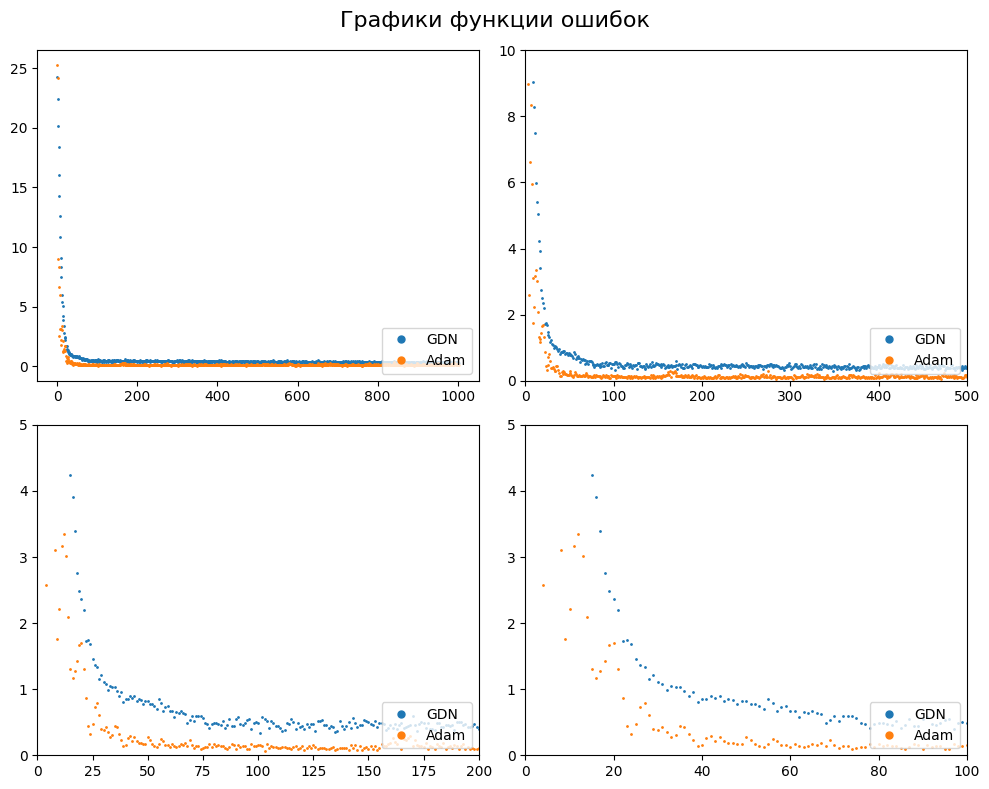

In [1855]:
x_gdn = np.arange(1, len(mse_gdn) + 1)
x_adam = np.arange(1, len(mse_adam) + 1)

fig, axs = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle('Графики функции ошибок', fontsize=16)

axs[0,0].plot(x_gdn,		mse_gdn,	".", ms = 2, label='GDN')
axs[0,0].plot(x_adam,		mse_adam,	".", ms = 2, label='Adam')
axs[0,0].legend()
axs[0,0].legend(loc='lower right', markerscale=5)

axs[0,1].plot(x_gdn,		mse_gdn,	".", ms = 2, label='GDN')
axs[0,1].plot(x_adam,		mse_adam,	".", ms = 2, label='Adam')
axs[0,1].set_xlim(0, 500)
axs[0,1].set_ylim(0, 10)
axs[0,1].legend()
axs[0,1].legend(loc='lower right', markerscale=5)

axs[1,0].plot(x_gdn,		mse_gdn,	".", ms = 2, label='GDN')
axs[1,0].plot(x_adam,		mse_adam,	".", ms = 2, label='Adam')
axs[1,0].set_xlim(0, 200)
axs[1,0].set_ylim(0, 5)
axs[1,0].legend()
axs[1,0].legend(loc='lower right', markerscale=5)

axs[1,1].plot(x_gdn,		mse_gdn,	".", ms = 2, label='GDN')
axs[1,1].plot(x_adam,		mse_adam,	".", ms = 2, label='Adam')
axs[1,1].set_xlim(0, 100)
axs[1,1].set_ylim(0, 5)
axs[1,1].legend()
axs[1,1].legend(loc='lower right', markerscale=5)

plt.tight_layout()
plt.show()

Как мы видим, GDN не слишком плох в данной задаче, чтобы им пренебрегать. К тому же, GDN проще и быстрее чем полный Adam (не стохастический) из-за того, что в Adam требуется дополнительная память для хранения и требуется большее число умножений (примерно на порядок больше)

### Определение гиперпараметров

Теперь для данной задачи необходимо определить наилучшие параметры модели: скорость обучения, коэффициент в функции активации

In [1856]:
# Перебираемые LF
LearningFactor = np.array([10**(-3),10**(-4),10**(-5),10**(-6),10**(-7),10**(-8),10**(-9),10**(-10)])

# Перебираемые Alpha
Alpha = np.array([0.5, 0.2, 0.1, 0.05, 0.02, 0.01, 0.005, 0.002, 0.001])

mse_gdn = np.zeros((len(LearningFactor),len(Alpha),100))

good_case = np.zeros((0,2))

In [1857]:
for i in range(len(LearningFactor)):
    for j in range(len(Alpha)):
        
        LF = LearningFactor[i]
        alpha = Alpha[j]
        
        U = np.random.randn(100, 1000) * 0.01
        W = np.random.randn(1000, 10) * 0.01

        T = np.tile(np.arange(10), (32, 1))

        flag = 1
        iteration = 0
        while (flag):
            
            X = np.random.rand(32, 100) * 100
            B = np.dot(X, U)
            H = LReLU(B,alpha)
            P = np.dot(H,W)
            Y = LReLU(P,alpha)
            
            current_error = MSE(Y,T)
            mse_gdn[i,j,iteration] = current_error
            
            temp = LReLU_D(P,alpha) * (Y - T)  # Градиент ошибки для выхода
            grad_W = np.dot(np.transpose(H), temp)  # Градиент для W

            delta_H = np.dot(temp, W.T) * LReLU_D(B,alpha)  # Градиент для скрытого слоя
            grad_U = np.dot(np.transpose(X), delta_H)  # Градиент для U
            
            W = W - LF * grad_W
            U = U - LF * grad_U
            
            
            if (iteration >= 99):
                flag = 0
            iteration += 1
        iteration = 0
            
        X = np.random.rand(1, 100) * 100
        Y = forward(X, U, W, alpha)
        current_error = MSE(Y,T[0])
        if (math.isnan(current_error)):
            print("Bad  case", LearningFactor[i], "\t", Alpha[j])
        elif (current_error > 0.5):
            print("Okay case", LearningFactor[i], "\t", Alpha[j], "\tMSE", current_error)
        else:
            print("Good case", LearningFactor[i], "\t", Alpha[j], "\tMSE", current_error, end="\t")
            np.set_printoptions(suppress=True, precision=3)
            print(Y)
            good_case = np.vstack((good_case, np.array([i, j])))

C:\Users\fedor\AppData\Local\Temp\ipykernel_8292\3960492758.py:12: RuntimeWarning: overflow encountered in square
  return np.sum((a - b) ** 2) / np.size(a)


Bad  case 0.001 	 0.5
Bad  case 0.001 	 0.2


C:\Users\fedor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Bad  case 0.001 	 0.1
Bad  case 0.001 	 0.05
Bad  case 0.001 	 0.02
Bad  case 0.001 	 0.01
Bad  case 0.001 	 0.005
Bad  case 0.001 	 0.002
Bad  case 0.001 	 0.001
Bad  case 0.0001 	 0.5
Bad  case 0.0001 	 0.2
Bad  case 0.0001 	 0.1
Bad  case 0.0001 	 0.05
Bad  case 0.0001 	 0.02
Bad  case 0.0001 	 0.01
Bad  case 0.0001 	 0.005
Bad  case 0.0001 	 0.002
Bad  case 0.0001 	 0.001
Bad  case 1e-05 	 0.5
Bad  case 1e-05 	 0.2
Bad  case 1e-05 	 0.1
Bad  case 1e-05 	 0.05
Bad  case 1e-05 	 0.02
Good case 1e-05 	 0.01 	MSE 0.11113383312470501	[[-0.002  1.062  2.129  3.531  4.165  4.978  6.406  7.324  8.641  9.318]]
Okay case 1e-05 	 0.005 	MSE 7.0329208682415185
Okay case 1e-05 	 0.002 	MSE 16.378043342243718
Okay case 1e-05 	 0.001 	MSE 2.390167459857609
Good case 1e-06 	 0.5 	MSE 0.22387524305828793	[[0.326 0.926 1.774 3.456 4.357 5.124 6.592 6.759 7.519 7.958]]
Good case 1e-06 	 0.2 	MSE 0.09024926798078803	[[-0.032  0.566  1.972  3.177  3.989  5.536  5.955  6.819  7.615  8.541]]
Good case 1e

(12, 2)


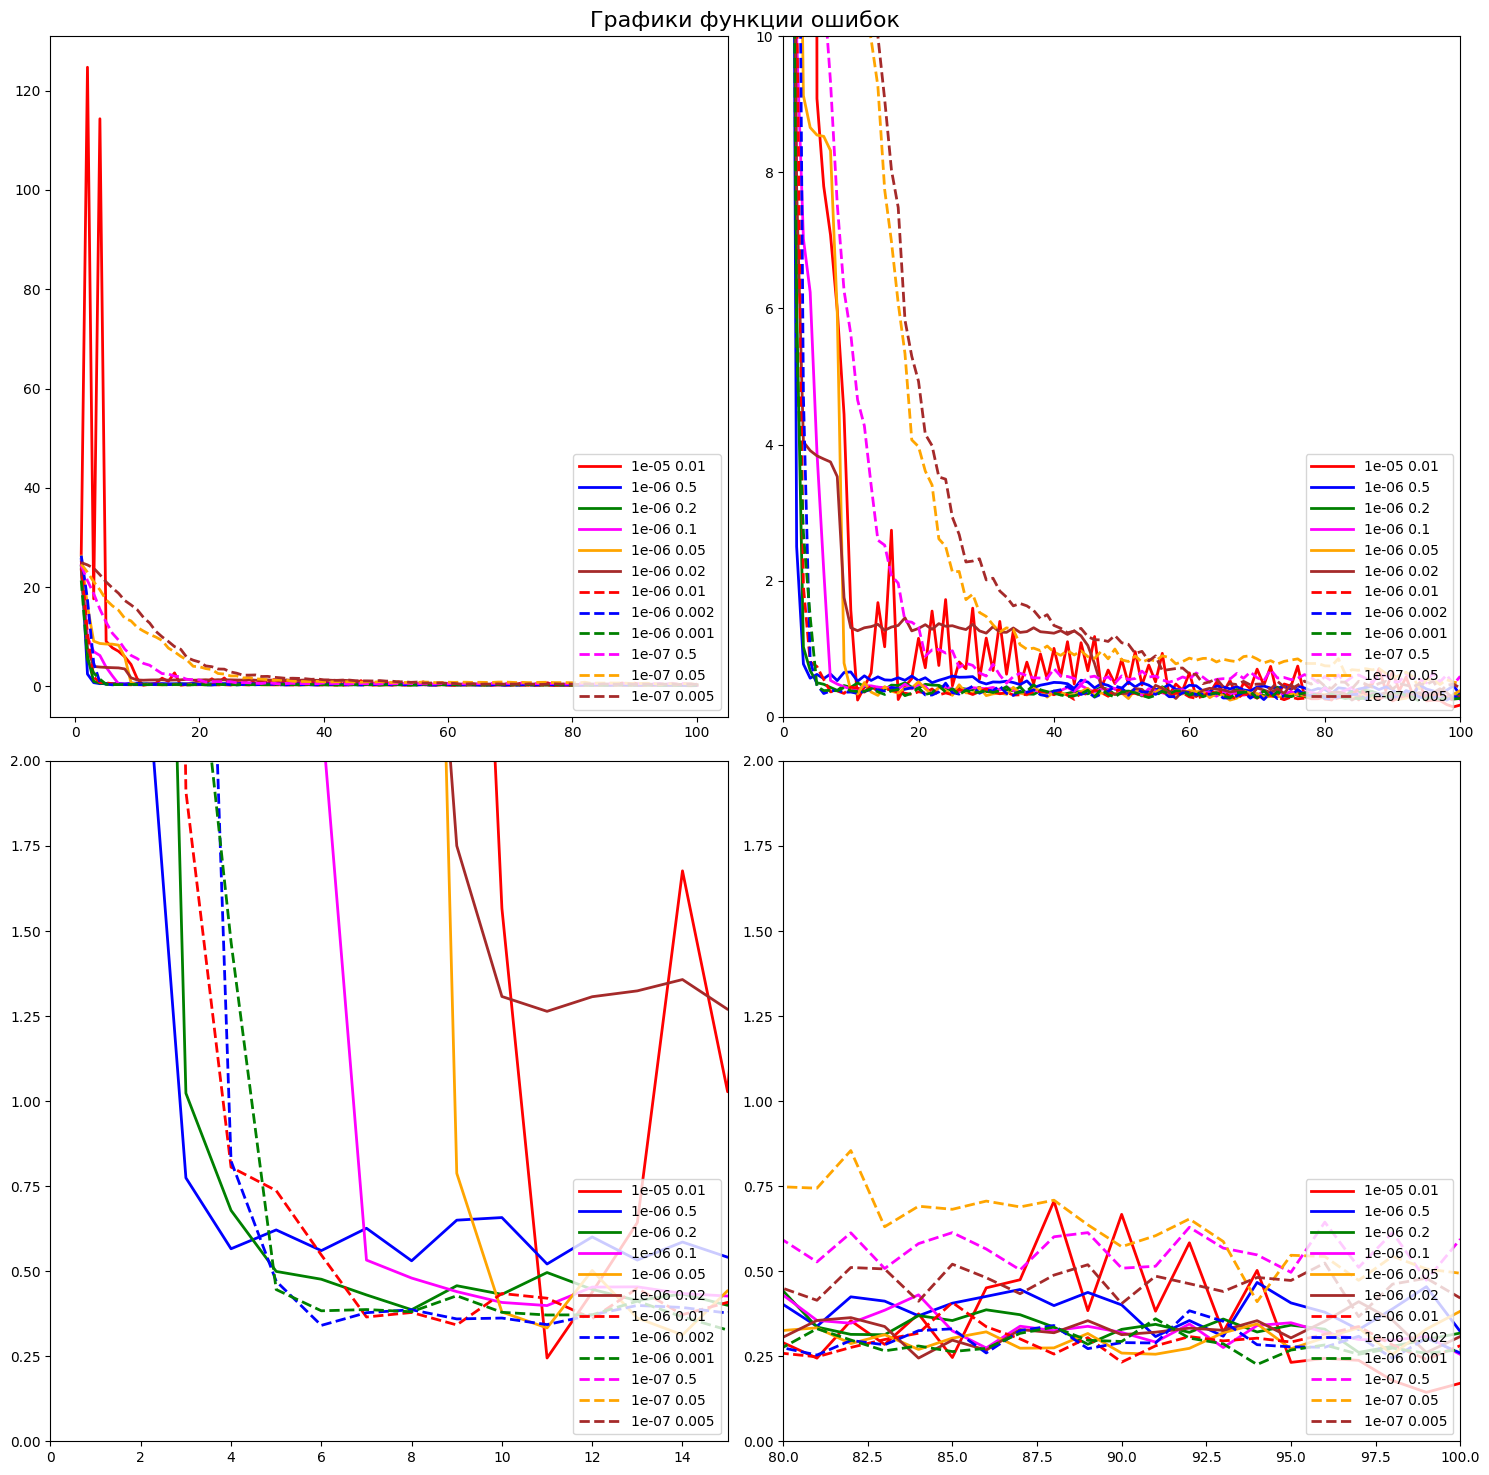

In [1858]:
epoch = np.arange(1, 101)

print(np.shape(good_case))

fig, axs = plt.subplots(2, 2, figsize=(15, 15))
fig.suptitle('Графики функции ошибок', fontsize=16)

styles = ['-', '--', '-.']
colors = ['red', 'blue', 'green', 'magenta','orange','brown']

for i in range(len(good_case)):
    k = int(good_case[i,0])
    p = int(good_case[i,1])
    
    name = str(LearningFactor[k]) + " " + str(Alpha[p])
    axs[0,0].plot(epoch,		mse_gdn[k,p],	color=colors[i % len(colors)],linestyle=styles[i // len(colors)], lw=2, label=name)
    axs[0,1].plot(epoch,		mse_gdn[k,p],	color=colors[i % len(colors)],linestyle=styles[i // len(colors)], lw=2, label=name)
    axs[1,0].plot(epoch,		mse_gdn[k,p],	color=colors[i % len(colors)],linestyle=styles[i // len(colors)], lw=2, label=name)
    axs[1,1].plot(epoch,		mse_gdn[k,p],	color=colors[i % len(colors)],linestyle=styles[i // len(colors)], lw=2, label=name)
    
axs[0,0].legend()
axs[0,1].set_xlim(0, 100)
axs[0,1].set_ylim(0, 30)
axs[0,0].legend(loc='lower right', handlelength=3)

axs[0,1].set_xlim(0, 100)
axs[0,1].set_ylim(0, 10)
axs[0,1].legend()
axs[0,1].legend(loc='lower right', handlelength=3)

axs[1,0].set_xlim(0, 15)
axs[1,0].set_ylim(0, 2)
axs[1,0].legend()
axs[1,0].legend(loc='lower right', handlelength=3)

axs[1,1].set_xlim(80, 100)
axs[1,1].set_ylim(0, 2)
axs[1,1].legend()
axs[1,1].legend(loc='lower right', handlelength=3)

plt.tight_layout()
plt.show()

Получилось, что самым лучшим значением гиперпараметра скорости обучнеия будет $10^{-6}$ и порог активации $0.05-0.2$

In [1870]:
SoM = 0

def LReLU(x, SoM, alpha=0.01):
    SoM += np.sum(x < 0)
    return np.where(x > 0, x, alpha * x), SoM

def forward(input, U, W, alpha=0.01):
    temp, trash = LReLU(np.dot(input, U), alpha)
    temp, trash = LReLU(np.dot(temp, W), alpha)
    return temp

mse_gdn = np.array([])
total_lrelu_mul = np.array([])
time_gdn = np.array([])

LF = 10**(-6)
alpha = 0.1

U = np.random.randn(100, 1000) * 0.01
W = np.random.randn(1000, 10) * 0.01

T = np.tile(np.arange(10), (32, 1))

max_iteration = 10000
flag = 1
iteration = 0
start_time_gdn = get_cpu_time()
while (flag):
	
	X = np.random.rand(32, 100) * 100
	B = np.dot(X, U)
	H,SoM = LReLU(B, SoM, alpha)
	P = np.dot(H, W)
	Y,SoM = LReLU(P, SoM, alpha)
	
	current_error = MSE(Y,T)
	mse_gdn = np.append(mse_gdn, current_error)
	
	grad_Y = LReLU_D(P,alpha) * (Y - T)  # Градиент ошибки для выхода
	grad_W = np.dot(np.transpose(H), grad_Y)  # Градиент для W

	delta_H = np.dot(grad_Y, W.T) * LReLU_D(B,alpha)  # Градиент для скрытого слоя
	grad_U = np.dot(np.transpose(X), delta_H)  # Градиент для U
	
	W = W - LF * grad_W
	U = U - LF * grad_U

	if (iteration >= max_iteration - 1):
		flag = 0
	time_gdn = np.append(time_gdn, get_cpu_time() - start_time_gdn)
	total_lrelu_mul = np.append(total_lrelu_mul, SoM)
	iteration += 1
	
	if iteration in np.array([10,100,1000,10000]):
		X = np.random.rand(1, 100) * 100
		Y = forward(X, U, W, alpha)
		np.set_printoptions(suppress=True, precision=3)
		print("Epoch", iteration, "\tMSE", f"{MSE(Y,T[0]):.6f}", end="\t")
		print(Y)
		print("Time", time_gdn[iteration - 1], "\tLReLU muls", total_lrelu_mul[iteration - 1])

Epoch 10 	MSE 0.266857	[[0.493 0.576 0.61  2.83  3.885 4.704 5.909 6.778 7.746 8.751]]
Time 0.0625 	LReLU muls 162239.0
Epoch 100 	MSE 0.330020	[[-0.006  0.512  2.093  2.192  3.986  4.205  5.811  5.745  7.882  8.622]]
Time 0.671875 	LReLU muls 1651746.0
Epoch 1000 	MSE 0.076270	[[-0.003  0.742  1.917  2.617  3.913  4.829  5.989  7.099  7.727  8.35 ]]
Time 5.71875 	LReLU muls 17443540.0
Epoch 10000 	MSE 0.066405	[[-0.001  0.594  1.948  2.415  4.219  4.831  5.75   6.947  8.028  8.889]]
Time 56.09375 	LReLU muls 182151496.0


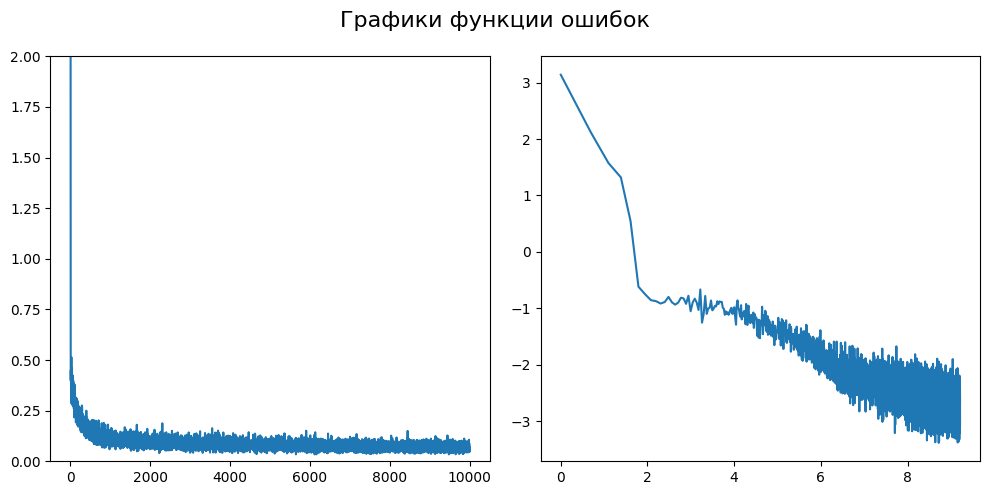

In [1871]:
epoch = np.arange(1, max_iteration + 1)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Графики функции ошибок', fontsize=16)

axs[0].plot(epoch, mse_gdn)
axs[0].set_ylim(0, 2)

axs[1].plot(np.log(epoch), np.log(mse_gdn))

plt.tight_layout()
plt.show()

# Расчёт задействованных ресурсов

### Ресурсы

Для расчёта задействованных ресурсов необходимо замерить время исполнения и информация об процессоре: в моём случае это Intel Core I5 8300H - 4 процессора 8 потоков с тактовой частотой 2.8 ГГц.

Время затраченное на обучение в зависимости от эпохи отображено в таблице ниже. Результат обучения на конкретной эпохе продемонстрирован выше.

### Расчёт умножений

В соответствии со структурой нейронной сети, можно посчитать точное количество умножений типа float $\times$ float.

От прямых умножений весов (умножение от U и от W): $100*1000*32 + 1000*10*32 = 3520000$

От использование функицй весов (зависит от эпохи): было подсчитано, данные в таблице



In [1877]:
print("Epoch 10\t",int(total_lrelu_mul[9]))
print("Epoch 100\t",int(total_lrelu_mul[99]))
print("Epoch 1000\t",int(total_lrelu_mul[999]))
print("Epoch 10000\t",int(total_lrelu_mul[9999]))

Epoch 10	 162239
Epoch 100	 1651746
Epoch 1000	 17443540
Epoch 10000	 182151496


Расчёт ошибки: $10 * 2 * 32 + 1 = 641$ 

От умножений в обратном распространении ошибки:
- градиент ошибки по Y: $10 * 32 = 320$
- градиент ошибки по W: $10*32*1000 = 320000$
- градиент ошибки по H: $32*10*1000 + 32*1000 = 352000$
- градиент ошибки по U: $32*1000*100 = 3200000$
- обновление весов U: $100*1000 = 100000$
- обновление весов W: $1000*10 = 10000$

**Итого умножений в эпоху (без умножения в LReLU): $7502961$**

### Итог

In [1889]:
TpT_10 = time_gdn[9] * 2.8*10**9/(int(total_lrelu_mul[9])+7502961*10)
TpT_100 = time_gdn[99] * 2.8*10**9/(int(total_lrelu_mul[99])+7502961*100)
TpT_1000 = time_gdn[999] * 2.8*10**9/(int(total_lrelu_mul[999])+7502961*1000)
TpT_10000 = time_gdn[9999] * 2.8*10**9/(int(total_lrelu_mul[9999])+7502961*10000)

print("Epoch 10\tmuls",		int(total_lrelu_mul[9])		+7502961*10,	"\ttime", time_gdn[9],		"\ttick/muls", TpT_10)
print("Epoch 100\tmuls",	int(total_lrelu_mul[99])	+7502961*100,	"\ttime", time_gdn[99],		"\ttick/muls", TpT_100)
print("Epoch 1000\tmuls",	int(total_lrelu_mul[999])	+7502961*1000,	"\ttime", time_gdn[999],	"\ttick/muls", TpT_1000)
print("Epoch 10000\tmuls",	int(total_lrelu_mul[9999])	+7502961*10000,	"\ttime", time_gdn[9999],	"\ttick/muls", TpT_10000)

Epoch 10	muls 75191849 	time 0.0625 	tick/muls 2.3273799265130455
Epoch 100	muls 751947846 	time 0.671875 	tick/muls 2.5018357456668605
Epoch 1000	muls 7520404540 	time 5.71875 	tick/muls 2.129207267352668
Epoch 10000	muls 75211761496 	time 56.09375 	tick/muls 2.088270462969453


In [1890]:
import pandas as pd

# Пример данных
epochs = [10, 100, 1000, 10000]
muls = [
    int(total_lrelu_mul[9]) + 7502961 * 10,
    int(total_lrelu_mul[99]) + 7502961 * 100,
    int(total_lrelu_mul[999]) + 7502961 * 1000,
    int(total_lrelu_mul[9999]) + 7502961 * 10000
]
times = [time_gdn[9], time_gdn[99], time_gdn[999], time_gdn[9999]]
tick_per_mul = [TpT_10, TpT_100, TpT_1000, TpT_10000]

data = {
    'Epoch': epochs,
    'Muls': muls,
    'Time': times,
    'Tick/Muls': tick_per_mul
}

df = pd.DataFrame(data)

df

,Epoch,Muls,Time,Tick/Muls
0,10,75191849,0.062500,2.327380
1,100,751947846,0.671875,2.501836
2,1000,7520404540,5.718750,2.129207
3,10000,75211761496,56.093750,2.088270


В среднем, за всё время обучения, затраченное количество тактов процессора на одно умножение составляет 2